# Deblending Example

Working through example code found in https://github.com/lsst-ts/ts_wep/blob/master/examples/deblendEimg.py

In [215]:
import os
import numpy as np
from matplotlib import pyplot as plt

from lsst.ts.wep.deblend.AdapThresImage import AdapThresImage
from lsst.ts.wep.deblend.BlendedImageDecorator import BlendedImageDecorator
from lsst.ts.wep.PlotUtil import plotImage
from lsst.ts.wep.Utility import getModulePath

from scipy.spatial.distance import cdist

#plt.style.use('dark_background')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
imageFile = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSep/sep_5/postage/extra_singleSciImg_sensor-R22_S11_star-0.txt'

In [3]:
imageIntra = AdapThresImage()
imageIntra.setImg(imageFile=imageFile)

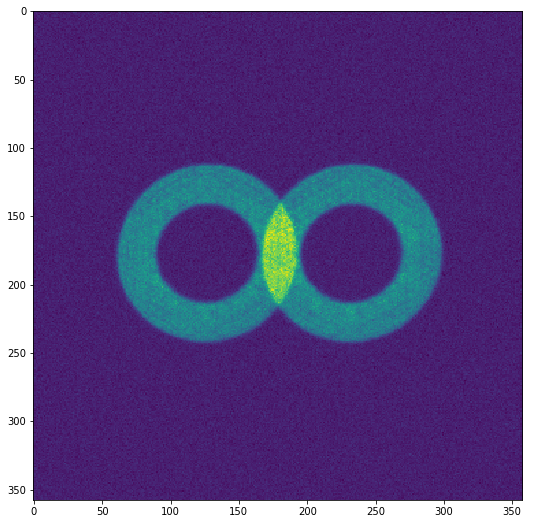

In [4]:
# Plot image
fig = plt.figure(figsize=(9,9))
plt.imshow(imageIntra.image)

In [5]:
image = imageIntra.image

In [272]:
# Final blended image
# blendImage = BlendedImage.BlendedImage(image=image, atype="intra")
blendImage = BlendedImageDecorator(new_centroid=True)
blendImage.setImg(image=image)

In [273]:
blendImage.new_centroid

True

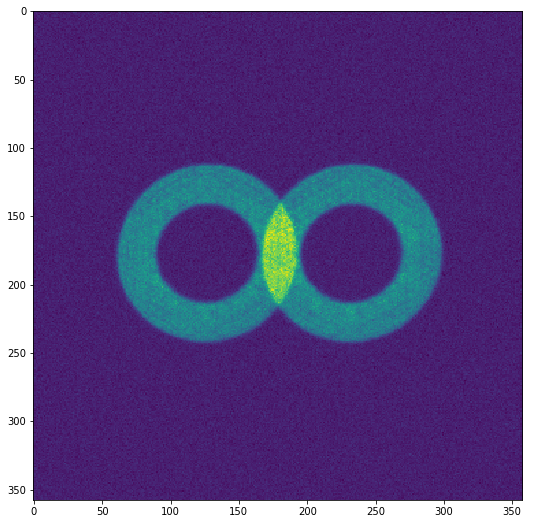

In [274]:
# Plot image
fig = plt.figure(figsize=(9, 9))
plt.imshow(blendImage.image)

In [275]:
neighborX, neighborY = (100, 180)

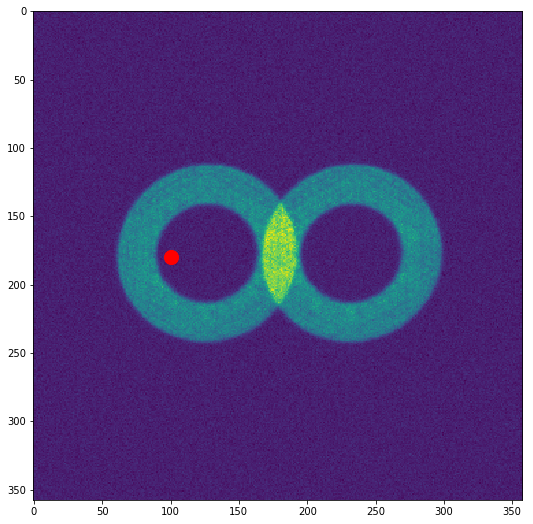

In [276]:
# Plot image
fig = plt.figure(figsize=(9, 9))
plt.imshow(blendImage.image)
plt.scatter(neighborX, neighborY, c='r', s=200)

In [314]:
# Do the deblending
imgDeblend, realcx, realcy = blendImage.deblendDonut((neighborY, neighborX), 2)

In [315]:
realcx, realcy

(233.00000000000006, 177.00000000000003)

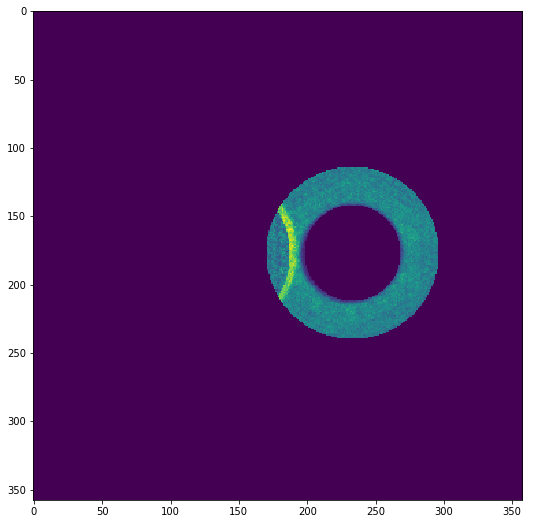

In [316]:
# Plot image
fig = plt.figure(figsize=(9, 9))
plt.imshow(imgDeblend)

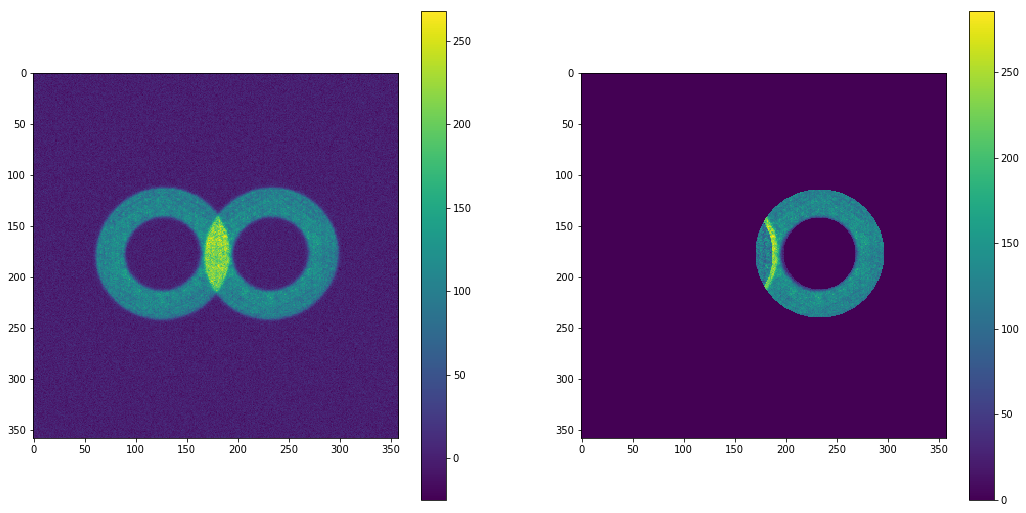

In [280]:
# Plot image
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.imshow(image)
plt.colorbar()
fig.add_subplot(1,2,2)
plt.imshow(imgDeblend)
plt.colorbar()

## Pulling apart `deblendDonut`

Method found here: https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/deblend/BlendedImageDecorator.py#L36

In [45]:
from scipy.ndimage.morphology import binary_opening, binary_closing, binary_erosion

In [16]:
blendImage_2 = BlendedImageDecorator()
blendImage_2.setImg(image=image)

Code tries to find centroid of brightest donut

In [17]:
# Deblended image
imgDeblend = []

iniGuessXY = (neighborX, neighborY)

# Postion of centroid

# Get the initial guess of brightest donut
centroidFind = blendImage_2.getCentroidFind()
imgBinary = centroidFind.getImgBinary(blendImage_2.getImg())
realcx, realcy, realR = centroidFind.getCenterAndRfromImgBinary(
    imgBinary)

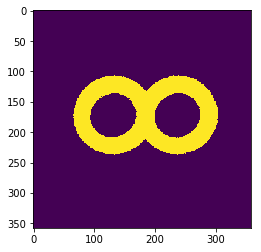

In [18]:
plt.imshow(imgBinary)

In [19]:
# Remove the salt and pepper noise of resImgBinary
imgBinary = binary_opening(imgBinary).astype(float)
imgBinary = binary_closing(imgBinary).astype(float)

Text(0.5, 1.0, 'Estimate Center and Radius')

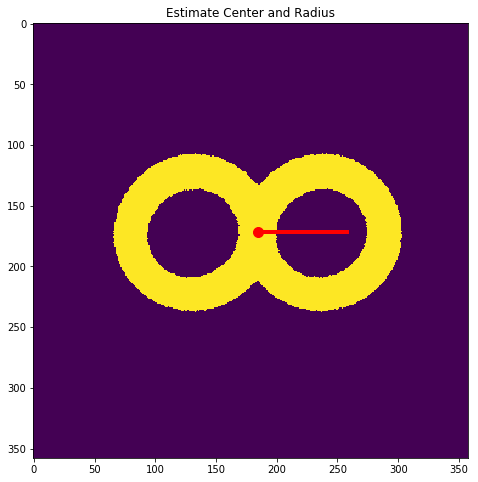

In [20]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgBinary)
plt.scatter(realcx, realcy, s=100, c='r')
plt.axhline(y=realcy, xmin=realcx/np.shape(imgBinary)[0], xmax=(realcx+realR)/np.shape(imgBinary)[0], lw=4, c='r')
plt.title('Estimate Center and Radius')

In [21]:
# Get the binary image by adaptive threshold
adapcx, adapcy, adapR, adapImgBinary = blendImage_2.getCenterAndR_adap()

#### To Do: What does adaptive image routine do differently than image binary method?

https://github.com/lsst-ts/ts_wep/blob/d32de1c93d067b48fb54dd0f4877d872e4b6f9e5/python/lsst/ts/wep/deblend/AdapThresImage.py#L95

Text(0.5, 1.0, 'Estimate Center and Radius')

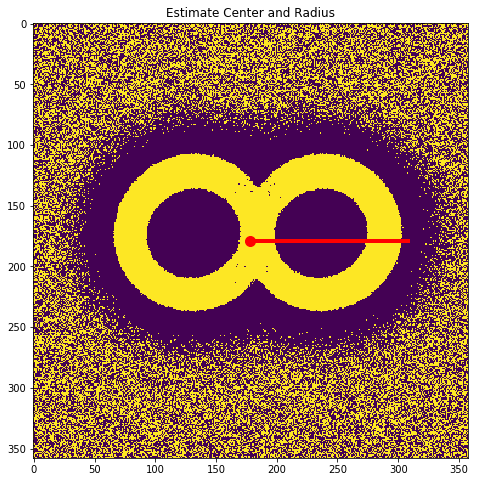

In [22]:
fig = plt.figure(figsize=(8,8))
plt.imshow(adapImgBinary)
plt.scatter(adapcx, adapcy, s=100, c='r')
plt.axhline(y=adapcy, xmin=adapcx/np.shape(adapImgBinary)[0], xmax=(adapcx+adapR)/np.shape(adapImgBinary)[0], lw=4, c='r')
plt.title('Estimate Center and Radius')

In [23]:
# Calculate the system error by only taking the background signal
bg1D = blendImage_2.getImg().flatten()
bgImgBinary1D = adapImgBinary.flatten()
background = bg1D[bgImgBinary1D == 0]  ## Only take background pixels from binary image
bgPhist, binEdges = np.histogram(background, bins=256)
sysError = np.mean(binEdges[0:2])

In [24]:
# Remove the system error
noSysErrImage = blendImage_2.getImg() - sysError
noSysErrImage[noSysErrImage < 0] = 0

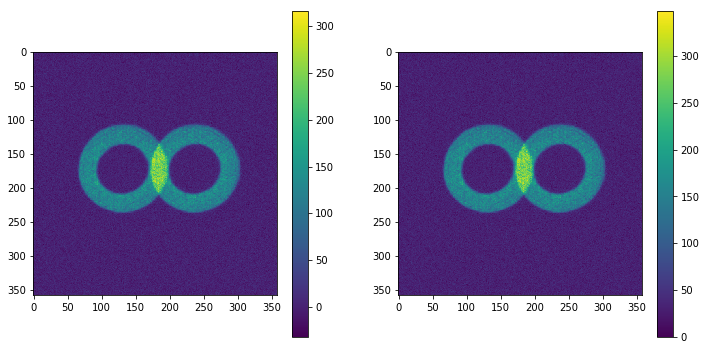

In [25]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.imshow(blendImage_2.getImg())
plt.colorbar()
fig.add_subplot(122)
plt.imshow(noSysErrImage)
plt.colorbar()

In [26]:
# Get the residue map
resImgBinary = adapImgBinary - imgBinary

In [27]:
# Compensate the zero element for subtraction
resImgBinary[np.where(resImgBinary < 0)] = 0

In [28]:
# Remove the salt and pepper noise noise of resImgBinary
resImgBinary = binary_opening(resImgBinary).astype(float)

Text(0.5, 1.0, 'Adaptive Binary Image - Binary Image')

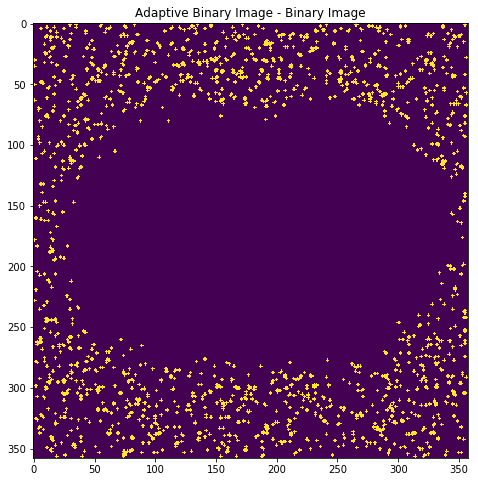

In [29]:
fig = plt.figure(figsize=(8,8))
plt.imshow(resImgBinary)
plt.title('Adaptive Binary Image - Binary Image')
# Basically finding the fainter donut

#### To Do: How does nelderMeadModify fit centers?

In [30]:
from lsst.ts.wep.deblend.nelderMeadModify import nelderMeadModify

# Calculate the shifts of x and y
x0 = int(iniGuessXY[0] - realcx)
y0 = int(iniGuessXY[1] - realcy)

xoptNeighbor = nelderMeadModify(blendImage_2._funcResidue, np.array([x0, y0]),
                                args=(imgBinary, resImgBinary), step=15)


In [31]:
xoptNeighbor

[array([-360.75  ,  -23.6875]), 7650.0]

In [32]:
from scipy.ndimage.interpolation import shift

# Shift the main donut image to fitted position of neighboring star
fitImgBinary = shift(imgBinary, [int(xoptNeighbor[0][1]), int(xoptNeighbor[0][0])])

In [33]:
# Handle the numerical error of shift. Regenerate a binary image.
fitImgBinary[fitImgBinary > 0.5] = 1
fitImgBinary[fitImgBinary < 0.5] = 0

In [34]:
xoptNeighbor

[array([-360.75  ,  -23.6875]), 7650.0]

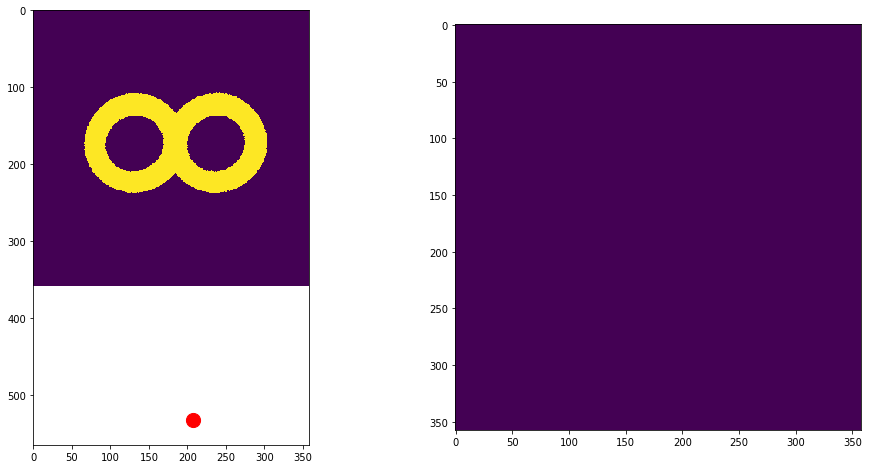

In [35]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(imgBinary)
plt.scatter(realcx - int(xoptNeighbor[0][1]), realcy - int(xoptNeighbor[0][0]), c='r', s=200)
fig.add_subplot(1,2,2)
plt.imshow(fitImgBinary)

In [36]:
# Get the overlap region between main donut and neighboring donut
imgOverlapBinary = imgBinary + fitImgBinary
imgOverlapBinary[imgOverlapBinary < 1.5] = 0
imgOverlapBinary[imgOverlapBinary > 1.5] = 1

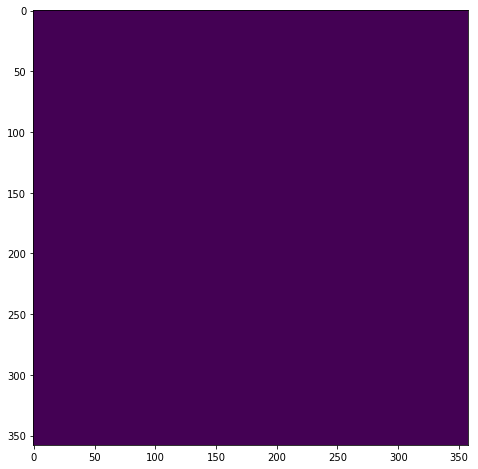

In [37]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgOverlapBinary)

In [38]:
# Get the overall binary image
imgAllBinary = imgBinary + fitImgBinary
imgAllBinary[imgAllBinary > 1] = 1

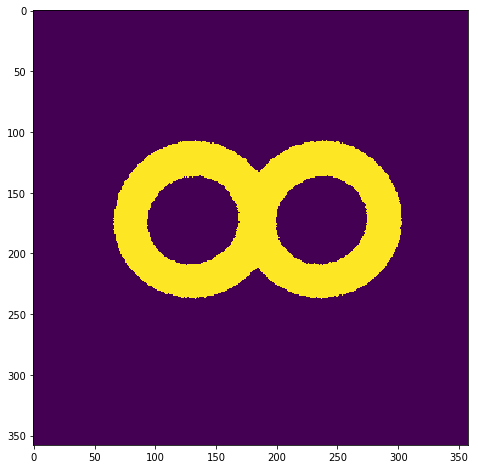

In [39]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgAllBinary)

In [40]:
# Get the reference image for the fitting
imgRef = noSysErrImage*imgAllBinary

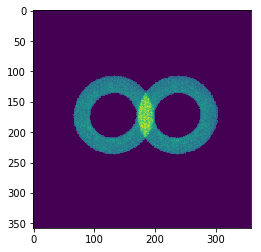

In [41]:
plt.imshow(imgRef)

In [42]:
# Calculate the magnitude ratio of image
imgMainDonut = noSysErrImage*imgBinary
imgFit = shift(imgMainDonut, [int(xoptNeighbor[0][1]), int(xoptNeighbor[0][0])])

In [43]:
from scipy.optimize import minimize_scalar

xoptMagNeighbor = minimize_scalar(
    blendImage_2._funcMag, bounds=(0, 1), method="bounded",
    args=(imgMainDonut, imgOverlapBinary, imgFit, imgRef, xoptNeighbor[0]))

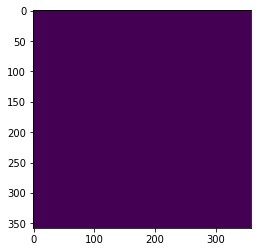

In [44]:
plt.imshow(xoptMagNeighbor.x*imgFit*imgOverlapBinary)

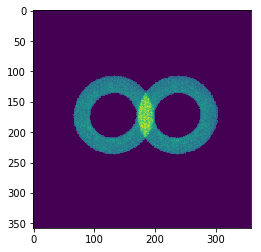

In [45]:
plt.imshow(imgMainDonut)

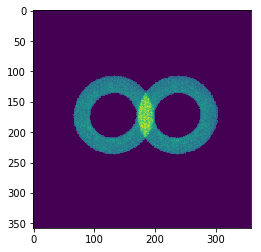

In [46]:
plt.imshow(imgMainDonut - xoptMagNeighbor.x*imgFit*imgOverlapBinary)

In [47]:
imgDeblend = imgMainDonut - xoptMagNeighbor.x*imgFit*imgOverlapBinary

In [48]:
# Repair the boundary of image
imgDeblend = blendImage_2._repairBoundary(imgOverlapBinary, imgBinary, imgDeblend)

In [49]:
from scipy.ndimage.measurements import center_of_mass

# Calculate the centroid position of donut
realcy, realcx = center_of_mass(imgBinary)

In [50]:
print(imgDeblend, realcx, realcy)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 184.83928571428572 171.6771978021978


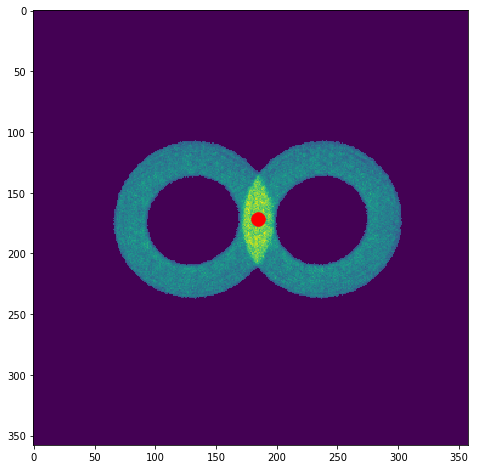

In [51]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgDeblend)
plt.scatter(realcx, realcy, c='r', s=180)

## New Method

In [46]:
image = blendImage.image
template_image = imageIntra.image

In [47]:
blendImage_2 = BlendedImageDecorator()
blendImage_2.setImg(image=image)

In [306]:
from skimage.draw import circle

def createTemplateImage():
    template_array = np.zeros((150, 150))
    rr, cc = circle(70, 70, 63, (150, 150))
    template_array[rr, cc] += 1
    rr_in, cc_in = circle(70, 70, 35, (150, 150))
    template_array[rr_in, cc_in] -= 1
    
    return template_array

In [307]:
template_image = createTemplateImage()

In [308]:
blendImage_template = BlendedImageDecorator()
blendImage_template.setImg(image=template_image)
templatecx, templatecy, templateR, templateImgBinary = blendImage_template.getCenterAndR_adap()

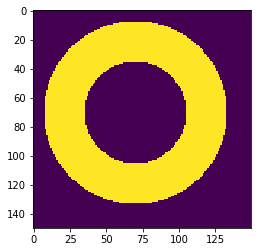

In [309]:
plt.imshow(templateImgBinary)

In [310]:
templatecx, templatecy

(70.0, 70.0)

In [52]:
from lsst.ts.wep.cwfs.Image import Image
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import getModulePath, getConfigDir, CamType

In [53]:
# Load Instrument parameters
instDir = os.path.join(getConfigDir(), "cwfs", "instData")
dimOfDonutOnSensor = 180
inst = Instrument(instDir)
inst.config(CamType.LsstCam, dimOfDonutOnSensor)

In [54]:
#create image for mask
img = CompensableImage()

In [55]:
#define postion of dounut in degrees relative to center of field
boundaryT = 0
maskScalingFactorLocal=1
img.fieldX=0. # 1.25
img.fieldY=0. # 1.15
img.makeMask(inst, "onAxis", boundaryT, maskScalingFactorLocal)

In [56]:
templatecx = 90
templatecy = 90

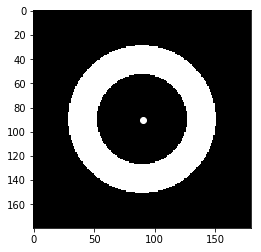

In [57]:
#display image with point indicating the center
plt.imshow(img.cMask, cmap='gray')
plt.scatter(templatecx, templatecy, c='w')
plt.show()

In [58]:
from scipy import ndimage
from sklearn.cluster import KMeans

def newCentroidFinder(imageBinary, templateImgBinary, n_donuts=2):
    temp_convolve = ndimage.convolve(imageBinary, templateImgBinary, mode='constant', cval=0.0)
    ranked_convolve = np.argsort(temp_convolve.flatten())[::-1]
    cutoff = len(np.where(temp_convolve.flatten() > 0.95*np.max(temp_convolve))[0])
    ranked_convolve = ranked_convolve[:cutoff]
    nx, ny = np.unravel_index(ranked_convolve, np.shape(imageBinary))

    kmeans = KMeans(n_clusters=n_donuts).fit(np.array([ny, nx]).T)
    labels = kmeans.labels_

    cent_x = []
    cent_y = []

    for label_num in range(n_donuts):
        nx_label, ny_label = np.unravel_index(ranked_convolve[labels == label_num][0], 
                                              np.shape(imageBinary))
        cent_x.append(nx_label)
        cent_y.append(ny_label)

    return cent_y, cent_x

In [59]:
templateImgBinary = img.cMask

In [288]:
# Deblended image
imgDeblend = []

iniGuessXY = (neighborX, neighborY)

# Postion of centroid

# Get the initial guess of brightest donut
#centroidFind = blendImage_2.getCentroidFind()
adapcx, adapcy, adapR, adapImgBinary = blendImage_2.getCenterAndR_adap()
cx_list, cy_list = newCentroidFinder(adapImgBinary, templateImgBinary)

In [289]:
# Order the centroids to figure out which is neighbor star
centroid_dist = cdist(np.array([iniGuessXY]),
                      np.array([cx_list, cy_list]).T)
iniGuess_dist_order = np.argsort(centroid_dist[0])
# Update coords of neighbor star and bright star with centroid pos
realcx = cx_list[iniGuess_dist_order[1]]
realcy = cy_list[iniGuess_dist_order[1]]
iniGuessXY = [cx_list[iniGuess_dist_order[0]], 
              cy_list[iniGuess_dist_order[0]]]

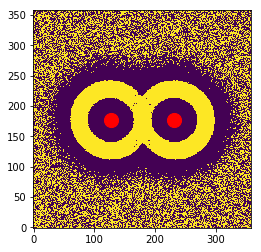

In [290]:
plt.imshow(adapImgBinary, origin='lower')
plt.scatter(cx_list, cy_list, c='r', s=200)

In [291]:
newImgBinary = np.zeros(np.shape(adapImgBinary))

In [292]:
newImgBinary[:np.shape(templateImgBinary)[0],
             :np.shape(templateImgBinary)[1]] += templateImgBinary

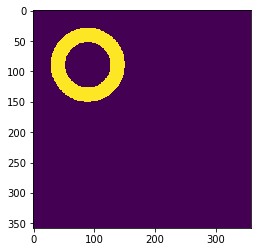

In [293]:
plt.imshow(newImgBinary)

In [294]:
from scipy.ndimage.interpolation import shift

x0 = int(realcx - templatecx)
y0 = int(realcy - templatecy)

# Shift the main donut image to fitted position of neighboring star
newImgBinary = shift(newImgBinary, [x0, y0])
newImgBinary[newImgBinary < 0] = 0

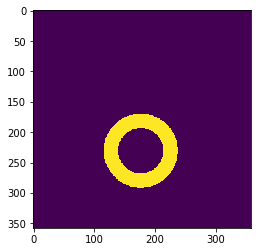

In [295]:
plt.imshow(newImgBinary)

In [296]:
from copy import deepcopy

imgBinary = deepcopy(newImgBinary)

In [297]:
# Get the binary image by adaptive threshold
adapcx, adapcy, adapR, adapImgBinary = blendImage_2.getCenterAndR_adap()

#### To Do: What does adaptive image routine do differently than image binary method?

https://github.com/lsst-ts/ts_wep/blob/d32de1c93d067b48fb54dd0f4877d872e4b6f9e5/python/lsst/ts/wep/deblend/AdapThresImage.py#L95

Text(0.5, 1.0, 'Estimate Center and Radius')

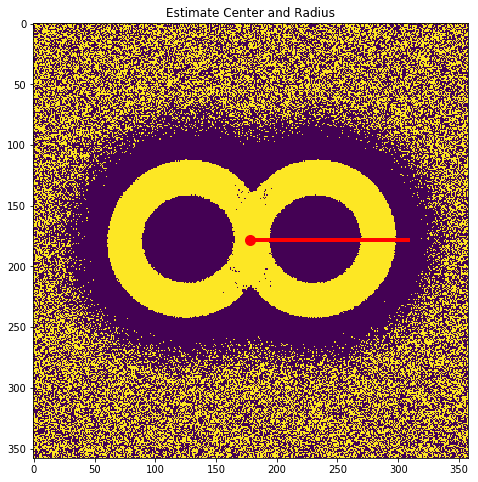

In [298]:
fig = plt.figure(figsize=(8,8))
plt.imshow(adapImgBinary)
plt.scatter(adapcx, adapcy, s=100, c='r')
plt.axhline(y=adapcy, xmin=adapcx/np.shape(adapImgBinary)[0], xmax=(adapcx+adapR)/np.shape(adapImgBinary)[0], lw=4, c='r')
plt.title('Estimate Center and Radius')

In [299]:
# Calculate the system error by only taking the background signal
bg1D = blendImage_2.getImg().flatten()
bgImgBinary1D = adapImgBinary.flatten()
background = bg1D[bgImgBinary1D == 0]  ## Only take background pixels from binary image
bgPhist, binEdges = np.histogram(background, bins=256)
sysError = np.mean(binEdges[0:2])

In [300]:
# Remove the system error
noSysErrImage = blendImage_2.getImg() - sysError
noSysErrImage[noSysErrImage < 0] = 0

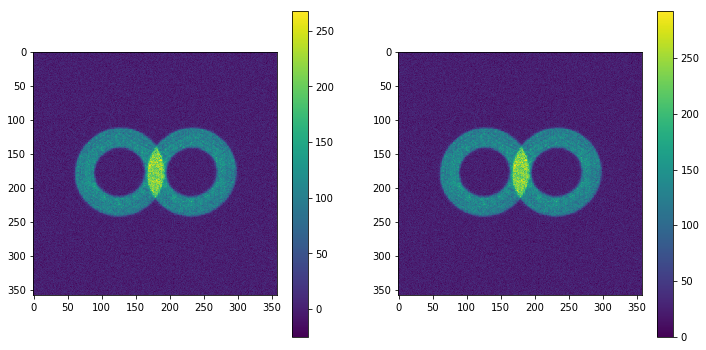

In [301]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.imshow(blendImage_2.getImg())
plt.colorbar()
fig.add_subplot(122)
plt.imshow(noSysErrImage)
plt.colorbar()

In [302]:
# Get the residue map
resImgBinary = adapImgBinary - imgBinary

In [303]:
# Compensate the zero element for subtraction
resImgBinary[np.where(resImgBinary < 0)] = 0

In [304]:
# Remove the salt and pepper noise noise of resImgBinary
resImgBinary = binary_opening(resImgBinary).astype(float)

Text(0.5, 1.0, 'Adaptive Binary Image - Binary Image')

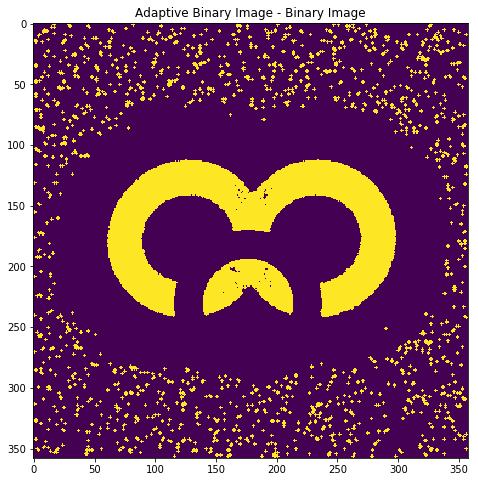

In [305]:
fig = plt.figure(figsize=(8,8))
plt.imshow(resImgBinary)
plt.title('Adaptive Binary Image - Binary Image')
# Basically finding the fainter donut

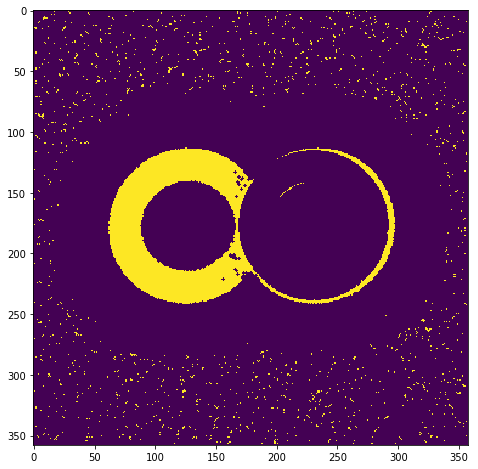

In [142]:
fig = plt.figure(figsize=(8,8))
plt.imshow(binary_erosion(resImgBinary))

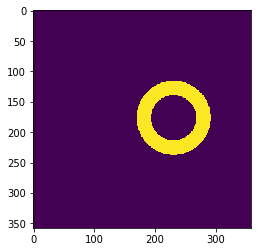

In [143]:
plt.imshow(imgBinary)

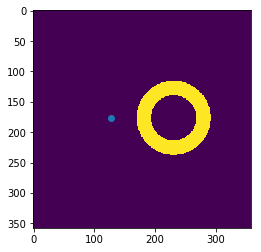

In [145]:
plt.imshow(imgBinary)
plt.scatter(iniGuessXY[0], iniGuessXY[1])

#### To Do: How does nelderMeadModify fit centers?

In [146]:
from lsst.ts.wep.deblend.nelderMeadModify import nelderMeadModify

# Calculate the shifts of x and y
x0 = int(iniGuessXY[0] - realcx)
y0 = int(iniGuessXY[1] - realcy)

xoptNeighbor = nelderMeadModify(blendImage_2._funcResidue, np.array([x0, y0]),
                                args=(imgBinary, resImgBinary), step=1.5)


In [147]:
print(x0, y0, xoptNeighbor[0]+[realcy, realcx], xoptNeighbor[1])

-104 0 [ 72.  231.5] 11223.0


In [148]:
from lsst.ts.wep.deblend.nelderMeadModify import nelderMeadModify

# Calculate the shifts of x and y
x0 = int(iniGuessXY[0] - realcx)
y0 = int(iniGuessXY[1] - realcy)

xoptNeighbor = nelderMeadModify(blendImage_2._funcResidue, np.array([y0, x0]),
                                args=(imgBinary, binary_erosion(resImgBinary)), step=1.5)


In [149]:
print(x0, y0, iniGuessXY, xoptNeighbor[0]+[realcy, realcx], xoptNeighbor[1])

-104 0 [127, 177] [180. 131.] 16823.0


In [150]:
xoptNeighbor

[array([   3., -100.]), 16823.0]

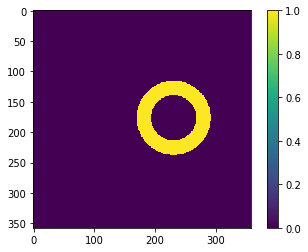

In [151]:
plt.imshow(imgBinary)
plt.colorbar()

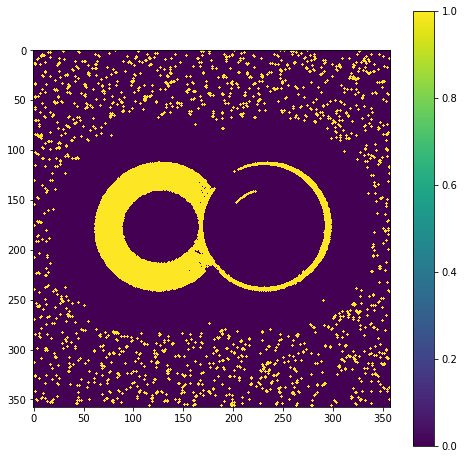

In [152]:
figure = plt.figure(figsize=(8,8))
plt.imshow(resImgBinary)
plt.colorbar()

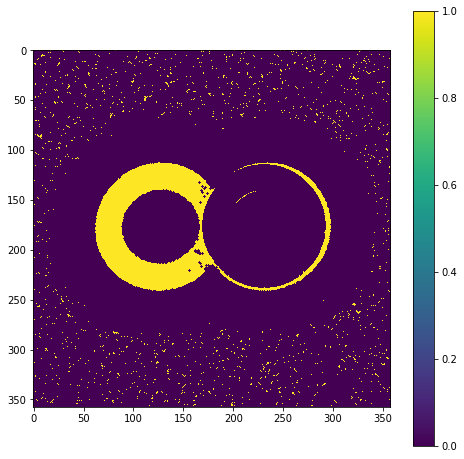

In [153]:
figure = plt.figure(figsize=(8,8))
plt.imshow(binary_erosion(resImgBinary)*1)
plt.colorbar()

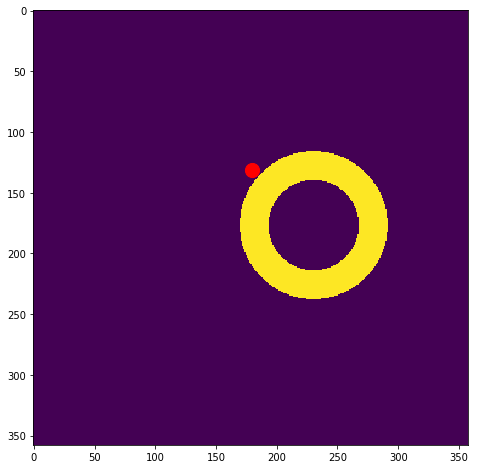

In [154]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgBinary)
plt.scatter(realcy + int(xoptNeighbor[0][0]), realcx +int(xoptNeighbor[0][1]), c='r', s=200)

In [158]:
from scipy.ndimage.interpolation import shift

# Shift the main donut image to fitted position of neighboring star
fitImgBinary = shift(imgBinary, [int(xoptNeighbor[0][0]), int(xoptNeighbor[0][1])])

In [159]:
# Handle the numerical error of shift. Regenerate a binary image.
fitImgBinary[fitImgBinary > 0.5] = 1
fitImgBinary[fitImgBinary < 0.5] = 0

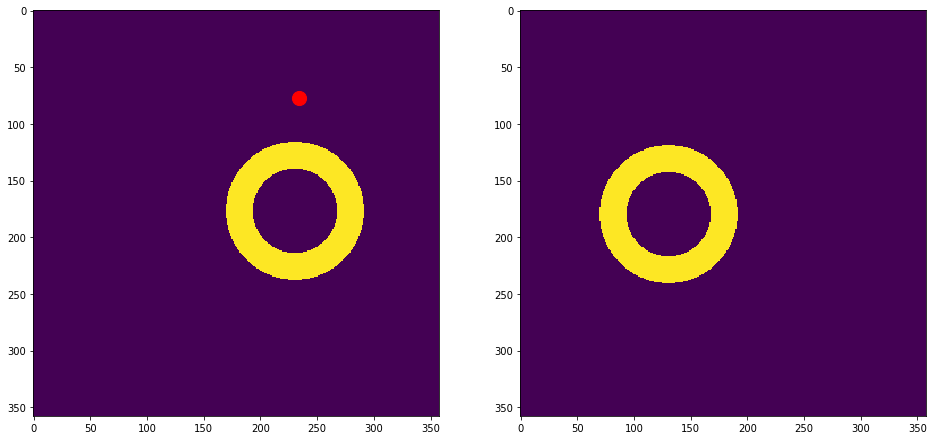

In [160]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(imgBinary)
plt.scatter(realcx + int(xoptNeighbor[0][0]), realcy + int(xoptNeighbor[0][1]), c='r', s=200)
fig.add_subplot(1,2,2)
plt.imshow(fitImgBinary)

In [329]:
# Get the overlap region between main donut and neighboring donut
imgOverlapBinary = imgBinary + fitImgBinary
imgOverlapBinary[imgOverlapBinary < 1.5] = 0
imgOverlapBinary[imgOverlapBinary > 1.5] = 1

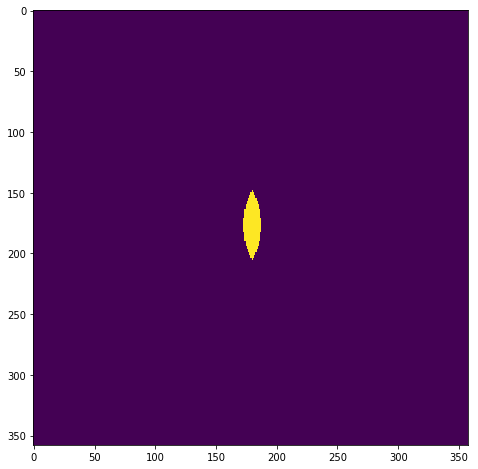

In [330]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgOverlapBinary)

In [331]:
# Get the overall binary image
imgAllBinary = imgBinary + fitImgBinary
imgAllBinary[imgAllBinary > 1] = 1

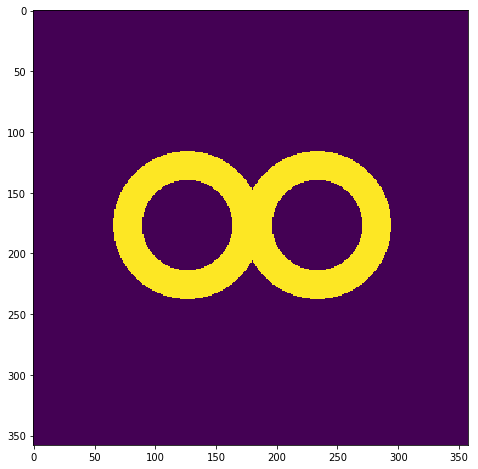

In [332]:
fig = plt.figure(figsize=(8,8))
plt.imshow(imgAllBinary)

In [333]:
# Get the reference image for the fitting
imgRef = noSysErrImage*imgAllBinary

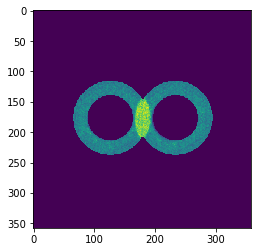

In [334]:
plt.imshow(imgRef)

In [335]:
# Calculate the magnitude ratio of image
imgMainDonut = noSysErrImage*imgBinary
imgFit = noSysErrImage*shift(imgBinary, [int(xoptNeighbor[0][1]), int(xoptNeighbor[0][0])])

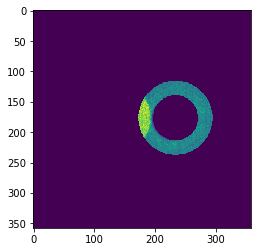

In [336]:
plt.imshow(imgFit)

In [337]:
from scipy.optimize import minimize_scalar

xoptMagNeighbor = minimize_scalar(
    blendImage_2._funcMag, bounds=(0, 1), method="bounded",
    args=(imgMainDonut, imgOverlapBinary, imgFit, imgRef, xoptNeighbor[0]))

In [338]:
xoptMagNeighbor

     fun: 20152130.90428721
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 0.839302871251335

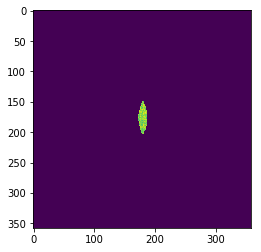

In [339]:
plt.imshow(xoptMagNeighbor.x*imgFit*imgOverlapBinary)

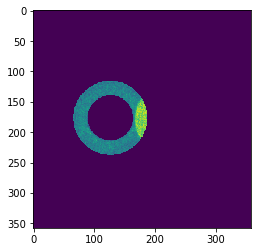

In [340]:
plt.imshow(imgMainDonut)

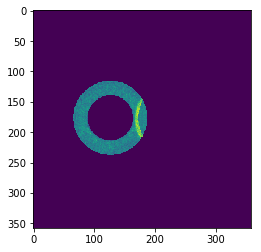

In [341]:
plt.imshow(imgMainDonut - 0.5*xoptMagNeighbor.x*imgFit*imgOverlapBinary)

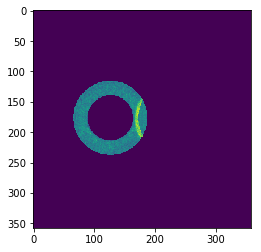

In [342]:
plt.imshow(imgMainDonut - 0.5*imgFit*xoptMagNeighbor.x*imgOverlapBinary)

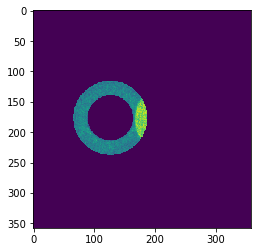

In [343]:
plt.imshow(imgMainDonut - xoptMagNeighbor.x*imgOverlapBinary)

In [344]:
imgDeblend = imgMainDonut - 0.5*xoptMagNeighbor.x*imgFit*imgOverlapBinary

In [345]:
# Repair the boundary of image
imgDeblend = blendImage_2._repairBoundary(imgOverlapBinary, imgBinary, imgDeblend)

In [346]:
from scipy.ndimage.measurements import center_of_mass

# Calculate the centroid position of donut
realcy, realcx = center_of_mass(imgBinary)

In [347]:
print(imgDeblend, realcx, realcy)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 3.17715429e-200]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  2.16688635e-200 0.00000000e+000]] 126.49999999999999 176.49999999999997


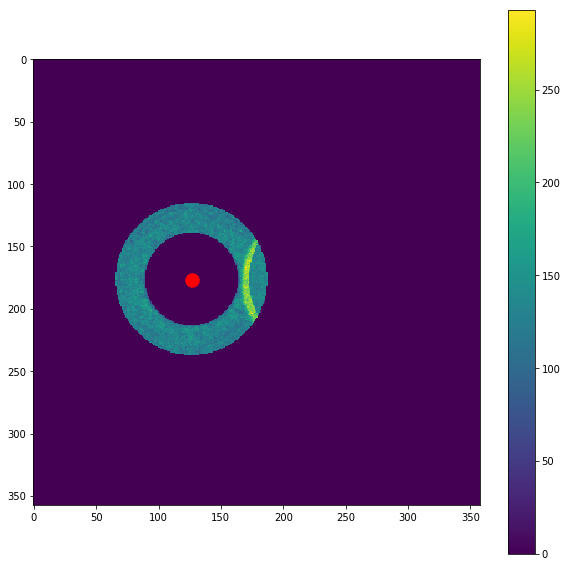

In [348]:
fig = plt.figure(figsize=(10,10))
plt.imshow(imgDeblend)
plt.colorbar()
plt.scatter(realcx, realcy, c='r', s=180)

In [349]:
fig = plt.figure(figsize=(10,10))
plt.imshow(np.sqrt((imgDeblend - imageMain)**2.), vmax=0.5)
plt.colorbar()

NameError: name 'imageMain' is not defined

<Figure size 720x720 with 0 Axes>

In [750]:
np.sum((imgDeblend - imageMain)**2.)

NameError: name 'imageMain' is not defined

In [491]:
plt.hist((imgDeblend.flatten() - imageMain.flatten())**2)
plt.yscale('log')
plt.axhline(10., 0., 3.)

NameError: name 'imageMain' is not defined

In [469]:
print('Mag Ratio = %.3f' % xoptMagNeighbor.x)

Mag Ratio = 0.978
